In [19]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils.data import DataLoader
import torchvision, numpy as np

In [10]:
batch_size = 64 if torch.cuda.is_available() else 16

### datasets and dataloaders

In [12]:

transforms = tfs.Compose([
    tfs.RandomCrop(32, padding=4),    
    tfs.RandomHorizontalFlip(),         
    tfs.ToTensor(),
    tfs.Normalize((0.4914, 0.4822, 0.4465),
                  (0.247, 0.2435, 0.2616))
])


train_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=True,
    transform=transforms,
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


test_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=False,
    transform=transforms,
)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

<>:11: SyntaxWarning: invalid escape sequence '\K'
<>:21: SyntaxWarning: invalid escape sequence '\K'
<>:11: SyntaxWarning: invalid escape sequence '\K'
<>:21: SyntaxWarning: invalid escape sequence '\K'
C:\Users\ahmad\AppData\Local\Temp\ipykernel_1416\618654969.py:11: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',
C:\Users\ahmad\AppData\Local\Temp\ipykernel_1416\618654969.py:21: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


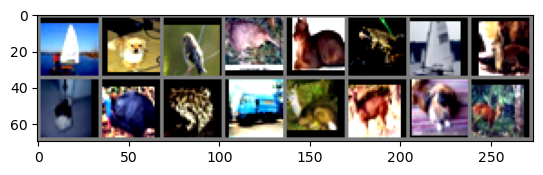

ship  dog   bird  bird  cat   frog  ship  deer  dog   bird  frog  truck deer  deer  dog   deer 


In [20]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions for showing an image :
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
